In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
import requests
import zipfile
from pathlib import Path


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL= drive+'model'


In [ ]:
# Setup path to data folder
data_path = Path(drive)
image_path = data_path / 'NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data'


In [ ]:
# with zipfile.ZipFile(image_path/'images.zip', "r") as zip_ref:
#         print("Unzipping data...")
#         zip_ref.extractall(image_path)

In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 11 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data'.
There are 1 directories and 2 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch'.
There are 0 directories and 3763 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/images'.
There are 0 directories and 237 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/images'.


In [ ]:
image_path

PosixPath('/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data')

In [ ]:
df_train_raw = pd.read_csv(image_path/'ndbufes_TaskIV_parsed_folders.csv')
df_test = pd.read_csv(image_path/'ndbufes_TaskIV_parsed_test.csv')
df_test.sample(3)

,localization_Tongue,localization_Lip,localization_Floor of mouth,localization_Buccal mucosa,localization_Palate,localization_Gingiva,larger_size,tobacco_use_Yes,tobacco_use_Former,tobacco_use_No,...,sun_exposure_Not informed,gender_M,gender_F,age_group_2,age_group_1,age_group_0,path,TaskIV,folder,label_number
29,0,1,0,0,0,0,1.0,0,0,1,...,0,1,0,1,0,0,0171.png,Leukoplakia with dysplasia,6,0
28,1,0,0,0,0,0,0.4,0,0,0,...,1,1,0,1,0,0,0156.png,OSCC,6,2
7,1,0,0,0,0,0,1.0,0,0,0,...,1,0,1,1,0,0,0034.png,OSCC,6,2


In [ ]:
# df['res'] = df.diagnosis + df.fillna('').dysplasia_severity
# df_x = df[['localization',
#        'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure',
#        'gender', 'skin_color', 'age_group', 'res']]
# x_df = df_x.drop(columns='res')
# x_df_img = df.path
# y_df = df_x.res

In [ ]:
# class_to_idx = y_df.unique()
# idx_to_class = {i:j for i, j in enumerate(class_to_idx) }
# idx_to_class

In [ ]:
df_train_raw.iloc[:,:-4].head(2)
df_train_raw.shape

(198, 27)

In [ ]:

int(df_train_raw.shape[0]*0.85)

168

In [ ]:
df_train = df_train_raw[:int(df_train_raw.shape[0]*0.85)]
df_val = df_train_raw[int(df_train_raw.shape[0]*0.85):]
df_train.shape, df_val.shape, df_test.shape

((168, 27), (30, 27), (39, 27))

In [ ]:
def getimg(df):
  image_data = []
  widgets = [' [', progressbar.Timer(format= 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('='), ' (', progressbar.ETA(), ') ']
  bar = progressbar.ProgressBar(max_value=len(df['path'])-1, widgets=widgets).start()
  for i in df['path']:
    image_data.append(img_to_array(load_img(image_path/'images'/i, target_size=(277,277)))/255)
    bar.update(i)
  return np.array(image_data)

In [ ]:
train_dataset = getimg(df_train)
val_dataset = getimg(df_val)
test_dataset = getimg(df_test)

168
30
39


In [ ]:
train_dataset.shape

(168, 277, 277, 3)

In [ ]:
idx_class = df_train_raw.TaskIV.unique().tolist()
class_idx = {j:i for i,j in enumerate(idx_class)}
class_idx, idx_class

({'OSCC': 0,
  'Leukoplakia with dysplasia': 1,
  'Leukoplakia without dysplasia': 2},
 ['OSCC', 'Leukoplakia with dysplasia', 'Leukoplakia without dysplasia'])

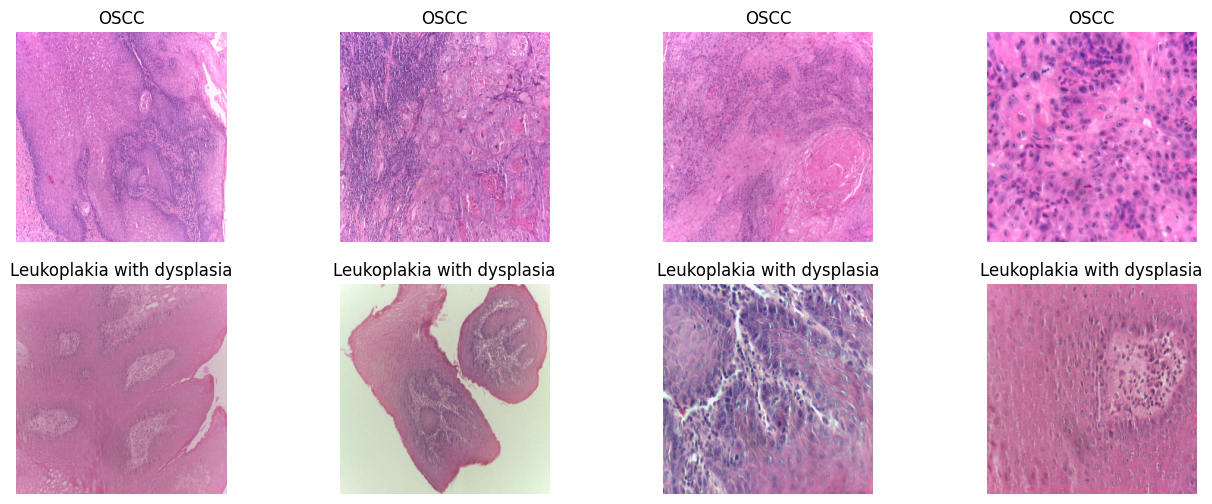

In [ ]:
plt.figure(figsize=(16,6))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.title(df_train.TaskIV[i])
  plt.axis('off')
  plt.imshow(train_dataset[i])

In [ ]:
# train_input = tf.data.Dataset.from_tensor_slices(df_train.iloc[:,:-4].values).batch(8)
# val_input = tf.data.Dataset.from_tensor_slices(df_val.iloc[:,:-4].values).batch(8)
# test_input = tf.data.Dataset.from_tensor_slices(df_test.iloc[:,:-4].values).batch(8)

# train_output = tf.data.Dataset.from_tensor_slices(df_train.TaskIV.apply(lambda x: class_idx[x]).values).batch(8)
# val_output = tf.data.Dataset.from_tensor_slices(df_val.TaskIV.apply(lambda x: class_idx[x]).values).batch(8)
# test_output = tf.data.Dataset.from_tensor_slices(df_test.TaskIV.apply(lambda x: class_idx[x]).values).batch(8)

In [ ]:
train_input = df_train.iloc[:,:-4].values
val_input = df_val.iloc[:,:-4].values
test_input = df_test.iloc[:,:-4].values

train_output = df_train.TaskIV.apply(lambda x: class_idx[x]).values
val_output = df_val.TaskIV.apply(lambda x: class_idx[x]).values
test_output = df_test.TaskIV.apply(lambda x: class_idx[x]).values

In [ ]:
len(train_input), type(train_output)

(168, numpy.ndarray)

In [ ]:
input_img_shape = train_dataset[0].shape  # (384, 512, 3)
input_txt_shape = (df_train.iloc[:,:-4].values.shape[1],)  # (23,)
output_shape = len(idx_class) # 3

input_img_shape, input_txt_shape, output_shape

((277, 277, 3), (23,), 3)

In [ ]:

image_input = keras.layers.Input(shape=input_img_shape)

x = keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)) (image_input)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(3,3)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Flatten() (x)


text_input = keras.layers.Input(shape=input_txt_shape)

y = keras.layers.Dense(23, activation='relu') (text_input)

f = keras.layers.concatenate([x, y])

z = keras.layers.Dense(1024, activation='relu') (f)
z = keras.layers.Dropout(0.5) (z)

z = keras.layers.Dense(1024, activation='relu') (z)
z = keras.layers.Dropout(0.5) (z)

output_layer = keras.layers.Dense(output_shape, activation='softmax') (z)

model = keras.Model(inputs=[image_input, text_input], outputs=output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 277, 277, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 67, 67, 128)          46592     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 67, 67, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 33, 33, 128)          0         ['batch_normalization[0][0

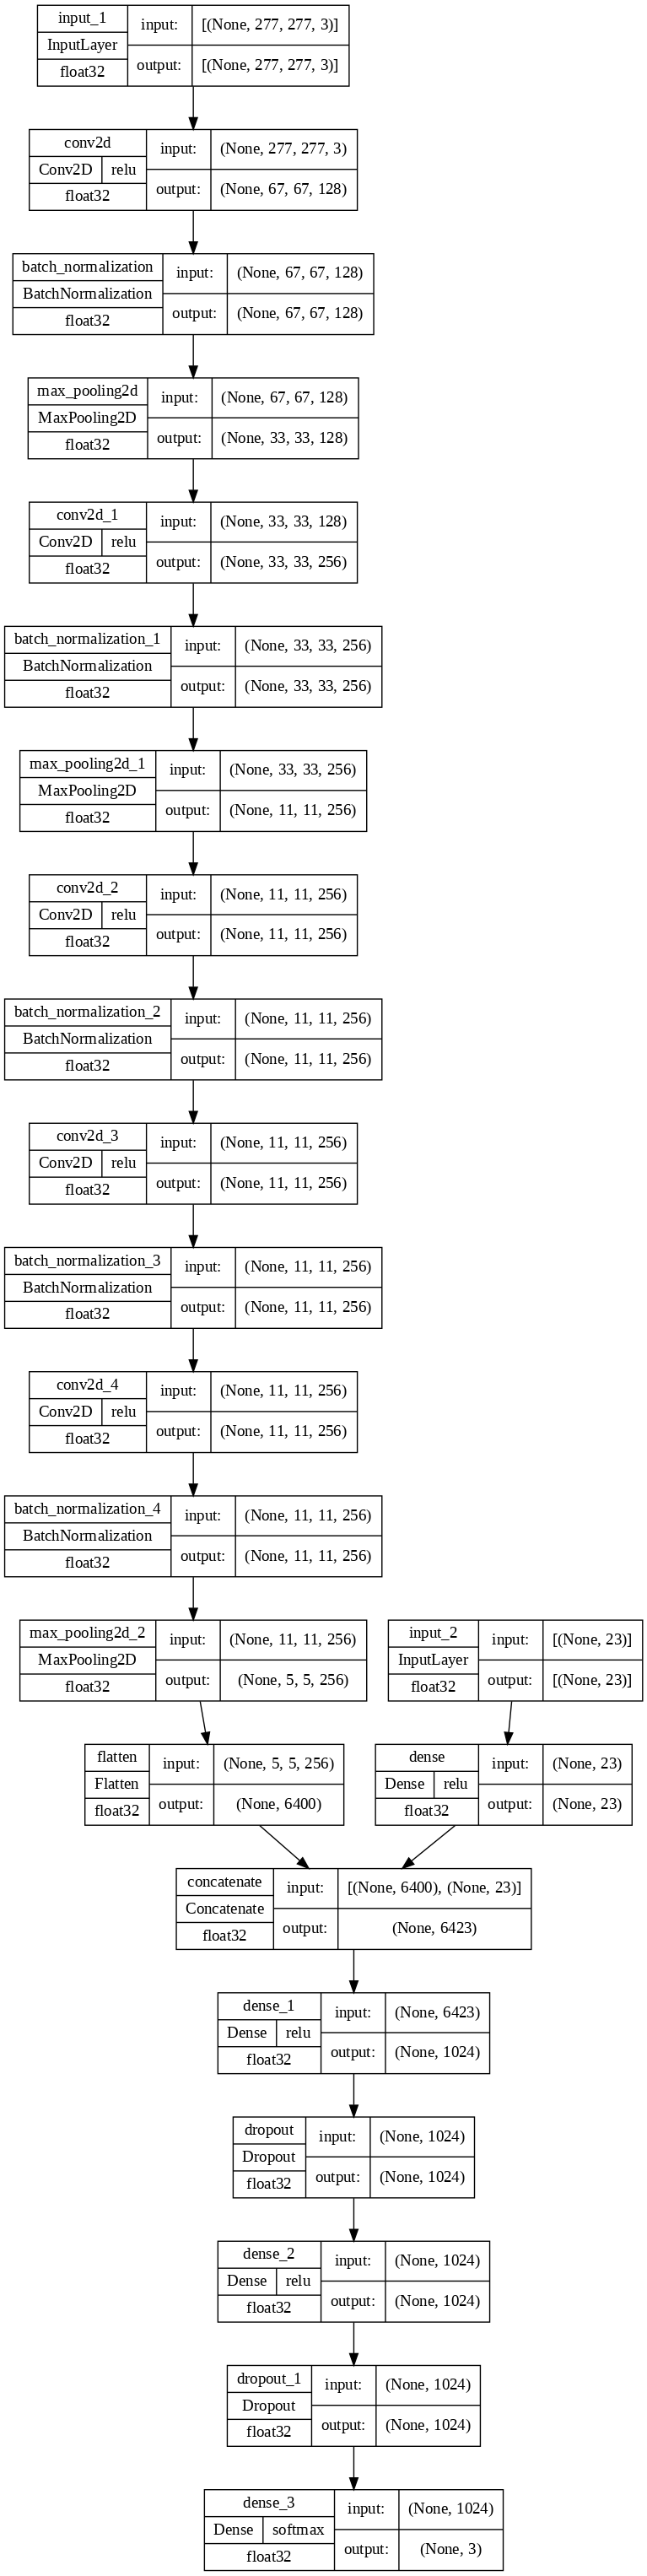

In [ ]:
keras.utils.plot_model(model, show_layer_activations=True, show_dtype=True, show_layer_names=True, show_shapes=True, dpi=100)

In [ ]:
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
# model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpointPath = data_path / 'model_w' / 'model1' / 'van'



mcp_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                       save_weights_only = True,
                                                       save_best_only = True,
                                                       monitor = 'val_loss',
                                                       verbose = 1)

es_point = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=50,
                                                        verbose=1,
                                                        restore_best_weights=True,
                                                        start_from_epoch=0,)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=.5,
                                                patience=2,
                                                verbose=1,
                                                mode='auto')

In [ ]:
history = model.fit([train_dataset,train_input], train_output, validation_data=([val_dataset,val_input],val_output), epochs=1000, batch_size=8, callbacks=[es_point])

Epoch 1/1000
21/21 [==============================] - 10s 83ms/step - loss: 6.2539 - accuracy: 0.4107 - val_loss: 23.6744 - val_accuracy: 0.5333
Epoch 2/1000
21/21 [==============================] - 0s 20ms/step - loss: 6.6278 - accuracy: 0.5238 - val_loss: 40.0407 - val_accuracy: 0.1667
Epoch 3/1000
21/21 [==============================] - 0s 22ms/step - loss: 4.7859 - accuracy: 0.5179 - val_loss: 6.8981 - val_accuracy: 0.3000
Epoch 4/1000
21/21 [==============================] - 0s 22ms/step - loss: 4.4349 - accuracy: 0.5536 - val_loss: 1.9400 - val_accuracy: 0.3000
Epoch 5/1000
21/21 [==============================] - 0s 21ms/step - loss: 3.9633 - accuracy: 0.5714 - val_loss: 3.8884 - val_accuracy: 0.5333
Epoch 6/1000
21/21 [==============================] - 0s 22ms/step - loss: 4.1650 - accuracy: 0.4702 - val_loss: 3.0273 - val_accuracy: 0.2667
Epoch 7/1000
21/21 [==============================] - 0s 23ms/step - loss: 2.5869 - accuracy: 0.5774 - val_loss: 1.9012 - val_accuracy: 0.5

In [ ]:
#  https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/#pyis-cta-modal
#  https://kumaramarjeet001.medium.com/converting-tensors-into-batches-74c400c6b16f

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,6.253937,0.410714,23.674395,0.533333
1,6.627830,0.523810,40.040703,0.166667
2,4.785930,0.517857,6.898080,0.300000
3,4.434925,0.553571,1.940044,0.300000
4,3.963253,0.571429,3.888405,0.533333


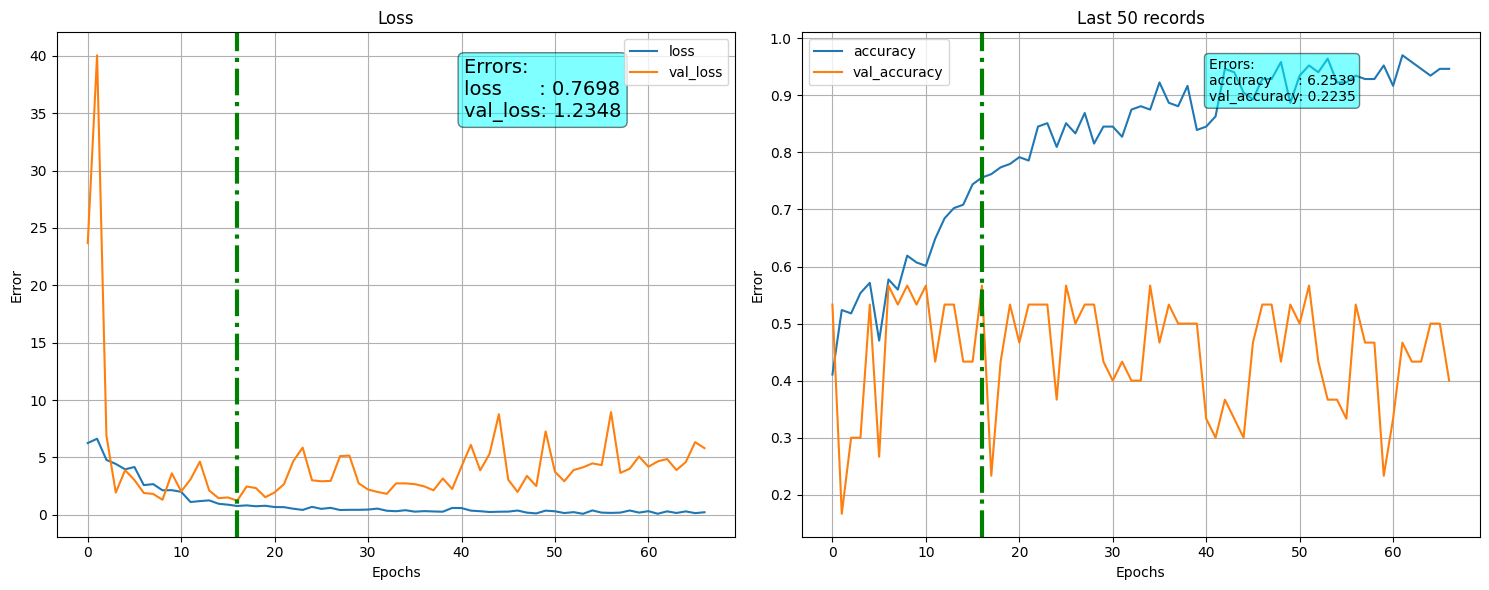

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))
props = dict(boxstyle='round', facecolor='aqua',alpha=.5)

l_range = 50
ax = axes[0]
y1=loss_df.columns[0]
y2=loss_df.columns[2]
best = loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]


loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \nloss      : {:6.4f}\nval_loss: {:6.4f}".format(best.loss.values[0],
                                                                    best.val_loss.values[0]) #text to plot

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(y1.capitalize())
ax.grid();

ax = axes[1]

y1=loss_df.columns[1]
y2=loss_df.columns[3]

loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \naccuracy      : {:6.4f}\nval_accuracy: {:6.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot


# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
16,0.76983,0.755952,1.234758,0.566667


In [ ]:
y_pred = model.predict([test_dataset, test_input])

2/2 [==============================] - 1s 313ms/step


In [ ]:
y_pred = [ np.argmax(i) for i in y_pred]
y_test = [ class_idx[i] for i in df_test.TaskIV.values]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
accuracy_score(y_test, y_pred)

0.5128205128205128

In [ ]:
confusion_matrix(y_test, y_pred)

array([[11,  2,  2],
       [ 5,  9,  1],
       [ 7,  2,  0]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.73      0.58        15
           1       0.69      0.60      0.64        15
           2       0.00      0.00      0.00         9

    accuracy                           0.51        39
   macro avg       0.39      0.44      0.41        39
weighted avg       0.45      0.51      0.47        39



In [ ]:
# ConfusionMatrixDisplay(df_test.TaskIV.values, np.array(y_pred))

In [ ]:
# https://medicus.ai/
# https://zini.ai/
# https://www.ai-medical.ch/